<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook evaluates the frozen features of a ResNet50 pre-trained (50 epochs of pre-training) using the [SimSiam method](https://arxiv.org/abs/2011.10566). You can refer to the [pre-training notebook here](https://github.com/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb). Following evaluation methods have been used - 

* Linear evaluation of the frozen features

*Please note that to keep this minimal I did not follow the original hyperparameter configurations rigorously.*  

## Initial setup

In [1]:
!nvidia-smi

Wed Dec  8 21:56:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:01:00.0  On |                  N/A |
|  8%   51C    P8    15W / 180W |    616MiB /  8111MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

## Dataset collection & preparation

The following code is referred from [here](https://github.com/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb). 

In [5]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "mnist",
    split=['train', 'test'],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    image = tf.image.grayscale_to_rgb(image)
    return (image, label)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2021-12-08 21:56:48.823287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 21:56:48.830677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 21:56:48.831158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 21:56:48.831746: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Utility functions

In [6]:
def get_model():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)

    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
    model   = tf.keras.Model(inputs, outputs)

    return model

In [7]:
get_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 27,804,554
Trainable params: 27,751,434
Non-trainable params: 53,120
____________________________________________

In [8]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

## Evaluation

In [9]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)

Epoch 1/50


2021-12-08 21:56:55.369315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-08 21:56:55.680778: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-08 21:56:55.681428: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-08 21:56:55.681449: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2021-12-08 21:56:55.682070: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-08 21:56:55.682116: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1875/1875 [==============================] - 618s 327ms/step - loss: 0.3563 - accuracy: 0.8956 - val_loss: 0.0986 - val_accuracy: 0.9700
Epoch 2/50
1875/1875 [==============================] - 610s 325ms/step - loss: 0.0919 - accuracy: 0.9725 - val_loss: 0.0799 - val_accuracy: 0.9765
Epoch 3/50
1875/1875 [==============================] - 612s 326ms/step - loss: 0.0704 - accuracy: 0.9785 - val_loss: 0.0578 - val_accuracy: 0.9838
Epoch 4/50
1875/1875 [==============================] - 610s 326ms/step - loss: 0.0569 - accuracy: 0.9832 - val_loss: 0.0459 - val_accuracy: 0.9861
Epoch 5/50
1875/1875 [==============================] - 611s 326ms/step - loss: 0.0455 - accuracy: 0.9863 - val_loss: 0.0364 - val_accuracy: 0.9882
Epoch 6/50
1875/1875 [==============================] - 615s 328ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 7/50
1875/1875 [==============================] - 613s 327ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 0.036

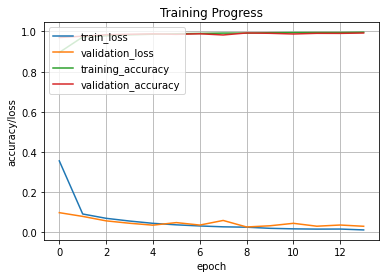

In [10]:
# Get linear model and compile
tf.keras.backend.clear_session()
model = get_model()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

# Train 
history = model.fit(training_ds,
                 validation_data=validation_ds,
                 epochs=50,
                 callbacks=[early_stopper]
                 )
plot_progress(history)

In [11]:
_, acc = model.evaluate(validation_ds)
print('Validation accuracy:', round(acc*100, 2))

313/313 [==============================] - 36s 115ms/step - loss: 0.0274 - accuracy: 0.9925
Validation accuracy: 99.25


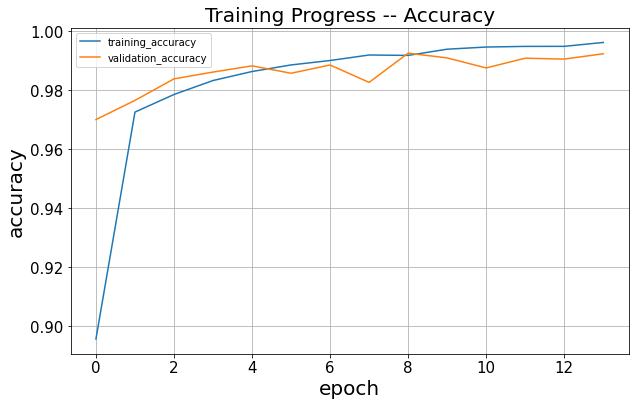

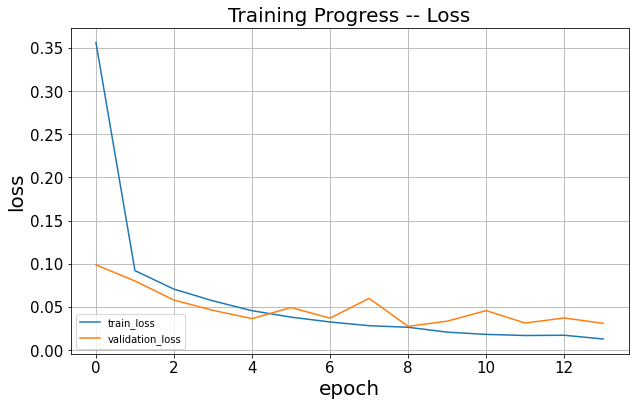

In [12]:
def plot_progress_acc(hist):
    fig, axs = plt.subplots(1,1, figsize=(10,6))
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress -- Accuracy", size=20)
    plt.ylabel("accuracy", size=20); plt.yticks(size=15)
    plt.xlabel("epoch", size=20); plt.xticks(size=15)
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

def plot_progress_loss(hist):
    fig, axs = plt.subplots(1,1, figsize=(10,6))
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.title("Training Progress -- Loss", size=20)
    plt.ylabel("loss", size=20); plt.yticks(size=15)
    plt.xlabel("epoch", size=20); plt.xticks(size=15)
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

plot_progress_acc(history)
plot_progress_loss(history)